## Basic structure

Various input files will be in disparate formats.  The intention here is to parse them into a standardized format.

* baseMethod.py contains a dataclass called **genericLoggerFile** which is the template for standardizing data and metadata between file types.
* All methods which parse a given file type, will 

In [1]:
import importlib
import baseMethods
importlib.reload(baseMethods)

# the .__dataclass_fields__ attribute prints the names of the fields in a dataclass and metadata like their default values
baseMethods.genericLoggerFile(sourceFile='some/path/to/a/file').__dataclass_fields__
# baseMethods._metadata(variableMap='a')

{'northOffset': Field(name='northOffset',type=<class 'float'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x0000017C045F8740>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=True,_field_type=_FIELD),
 'Latitude': Field(name='Latitude',type=<class 'float'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x0000017C045F8740>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=True,_field_type=_FIELD),
 'Longitude': Field(name='Longitude',type=<class 'float'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x0000017C045F8740>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=True,_field_type=_FIELD),
 'Elevation': Field(name='Elevation',type=<class 'float'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x0000017C045F8740>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=True,_field_type=_FIELD),
 'variable

## Parsing a Campbell Scientific File

The parseCSI module handles the logger-specific tasks.  There are a multiple different files formats which may be output from a campbell scientific logger.  So far, the module supports:


* **TOB3**: a machine readable (binary) data file along with a human readable text (ascii) header in comma delimited format.  "add link to docs"

* **TOA5**: a human readable text (ascii) file in comma delimited format.  "add link to docs"

If we want to parse a TOA5 file, we can call parseCSI.TOA5(sourceFile=path/to/your/file ), where sourcefile.  It will automatically parse out all relevant metadata contained within the file and convert to a standardized format which can be written to the database.  We can also overwrite the metadata as needed,

In [2]:
import parseCSI
importlib.reload(parseCSI)


file = 'example_data/TOA5_BBS.FLUX_2023_08_01_1530.dat'

TOA5_example = parseCSI.TOA5(sourceFile=file)

# The parseTOA5 dataclass has its onw fields plus all fields it inherits from the base dataclass (genericLoggerFile)
TOA5_example.__dataclass_fields__

{'northOffset': Field(name='northOffset',type=<class 'float'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x0000017C045F8740>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=True,_field_type=_FIELD),
 'Latitude': Field(name='Latitude',type=<class 'float'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x0000017C045F8740>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=True,_field_type=_FIELD),
 'Longitude': Field(name='Longitude',type=<class 'float'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x0000017C045F8740>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=True,_field_type=_FIELD),
 'Elevation': Field(name='Elevation',type=<class 'float'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x0000017C045F8740>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=True,_field_type=_FIELD),
 'variable

### Looking inside a parsed input file

The basic component of all processed logger files will include:

* A pandas DataFrame with a datetime index containing all data which can be read form the raw data file
    * timezone and frequency are metatadata provided as separate fields in the object
    * The routine will attempt to automatically parse the timestamp from the input files.  For standard file types (CSI, GHG, etc.) this is simple.  For some custom formats, the user will need to specify the timestamp format.
* a variableMap 
    * A mapping of each column in the dataframe to with metadata including.  Some of these metadata can be automatically parsed from the files, depending on the file type.  Otherwise the can be provided by the user (see next second code example below)
        * Original column name (spaces and special characters are replaced with _)
        * Units & data type
        * Sensor information 
        * Variable description

In [3]:
# the __dict__ attribute prints the names of the fields in a dataclass and their values
for key,value in TOA5_example.__dict__.items():
    print(f'{key}: {value}')

northOffset: None
Latitude: None
Longitude: None
Elevation: None
variableMap: {'RECORD': {'originalName': 'RECORD', 'safeName': 'RECORD', 'ignore': False, 'sensor': None, 'unit': 'RN', 'dtype': '<i8', 'variableDescription': ''}, 'Ux': {'originalName': 'Ux', 'safeName': 'Ux', 'ignore': False, 'sensor': None, 'unit': 'm/s', 'dtype': '<f8', 'variableDescription': 'Smp'}, 'Uy': {'originalName': 'Uy', 'safeName': 'Uy', 'ignore': False, 'sensor': None, 'unit': 'm/s', 'dtype': '<f8', 'variableDescription': 'Smp'}, 'Uz': {'originalName': 'Uz', 'safeName': 'Uz', 'ignore': False, 'sensor': None, 'unit': 'm/s', 'dtype': '<f8', 'variableDescription': 'Smp'}, 'Ts': {'originalName': 'Ts', 'safeName': 'Ts', 'ignore': False, 'sensor': None, 'unit': 'C', 'dtype': '<f8', 'variableDescription': 'Smp'}, 'sonic_diag': {'originalName': 'sonic_diag', 'safeName': 'sonic_diag', 'ignore': False, 'sensor': None, 'unit': 'arb', 'dtype': '<i8', 'variableDescription': 'Smp'}, 'CO2': {'originalName': 'CO2', 'safeNam

### Defining the variableMap

* The variableMap is a dictionary with a set of fields which are a applied on a per-column (variable) basis.  They can be user defined, or automatically parsed from the file where possible, or if all else values, the will take the default values defined for _variableMap.

* Say you want to overwrite the default metadata values for the "sonic_diag" column in example_data/TOA5_BBS.FLUX_2023_08_01_1530.dat because it is actually a counter variable that was misslabeled in the code.  We want to ignore the variable in further processing and add a note to explain why.  We can define variable map for sonic_diag while leaving all other information to be parsed automatically or set to the default.

* The variableMap for a given input file type for a given site/logger can then be saved as a YAML file so the metadata are in an easy to read format.  We still need to put in some thought into handling time-dependent updates to the metadata.  Where the metatada are common between timestamps we can minimize storage by having one yaml file per time-block.  When the metadata update we need a new file (full or just partial documenting changes 
    + I think full is more readable even if it takes more space).  We then need an time-dependent index of the metatada files so things can be matched up correctly.

In [5]:
TOA5_example_custom_varMap = parseCSI.TOA5(
    sourceFile=file,
    variableMap={'sonic_diag':{
        'variableDescription':'The diagnostic variable is corrupted and should be ignored',
        'ignore':True,
        'unit':'unitless',
        },
    }
)

import yaml
print(yaml.safe_dump(TOA5_example_custom_varMap.variableMap,sort_keys=False))

RECORD:
  originalName: RECORD
  safeName: RECORD
  ignore: false
  sensor: null
  unit: RN
  dtype: <i8
  variableDescription: ''
Ux:
  originalName: Ux
  safeName: Ux
  ignore: false
  sensor: null
  unit: m/s
  dtype: <f8
  variableDescription: Smp
Uy:
  originalName: Uy
  safeName: Uy
  ignore: false
  sensor: null
  unit: m/s
  dtype: <f8
  variableDescription: Smp
Uz:
  originalName: Uz
  safeName: Uz
  ignore: false
  sensor: null
  unit: m/s
  dtype: <f8
  variableDescription: Smp
Ts:
  originalName: Ts
  safeName: Ts
  ignore: false
  sensor: null
  unit: C
  dtype: <f8
  variableDescription: Smp
sonic_diag:
  originalName: sonic_diag
  safeName: sonic_diag
  ignore: true
  sensor: null
  unit: unitless
  dtype: <i8
  variableDescription: The diagnostic variable is corrupted and should be ignored
CO2:
  originalName: CO2
  safeName: CO2
  ignore: false
  sensor: null
  unit: mg/m3
  dtype: <f8
  variableDescription: Smp
H2O:
  originalName: H2O
  safeName: H2O
  ignore: false


## Parsing at TOB5 file

* Say you want to do the exact same thing as above, but for a TOB3 file.  Use can use the same syntax, just call parseCSI.TOB5() instead.

* Note, we can also set metadata fields which are not included in a file if needed, like the north offset 



In [6]:
file = 'example_data/Flux_Data640.dat'
TOB3_example = parseCSI.TOB3(sourceFile=file,northOffset=40)

# # the __dict__ attribute prints the names of the fields in a dataclass and their values
# for key,value in TOB3_example.__dict__.items():
#     print(f'{key}: {value}')
print(TOB3_example.northOffset)
TOB3_example.DataFrame.columns


40


Index(['Ux', 'Uy', 'Uz', 'Ts', 'Diagnostic_CSAT', 'CO2', 'H2O', 'press',
       'LI7500_diag', 'LI7550_SignalStrength', 'seconds', 'nanoseconds',
       'Diagnostic_7700', 'CH4_density', 'CH4_mole_fraction', 'Temperature',
       'Pressure', 'RSSI'],
      dtype='object')

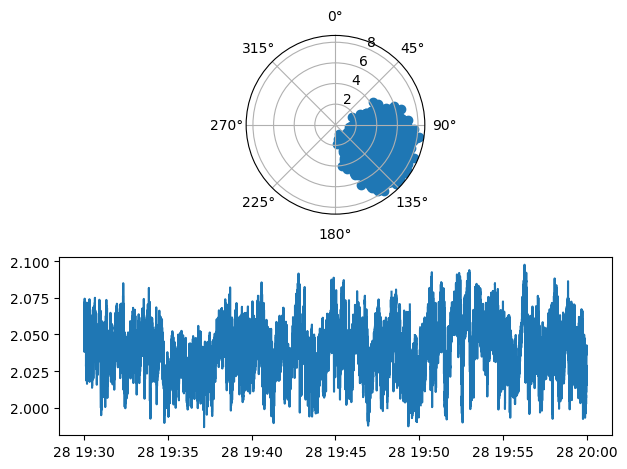

In [7]:
import matplotlib.pyplot as plt
import numpy as np

df = TOB3_example.DataFrame.copy()

df['wind_dir'] = np.rad2deg(np.arctan2(df['Ux'],df['Uy']))+TOB3_example.northOffset
df['wind_speed'] = (df['Ux']**2+df['Uy']**2)**.5


plt.figure()

ax1 = plt.subplot(2,1,1,polar=True)
ax2 = plt.subplot(2,1,2)

ax1.set_theta_direction(-1)
ax1.set_theta_offset(np.deg2rad(90))

y = df['Uy'].values
x = df['Ux'].values


# df[['wind_dir','wind_speed','Ux','Uy']]
ax1.scatter(np.deg2rad(df['wind_dir']),df['wind_speed'])

ax2.plot(df['CH4_mole_fraction'])

plt.tight_layout()

## Parsing CSV files

There are any number of different csv formats we may want to work with.  The parseCSV.genericCSV() should be able to handle most general use cases.  However we can create wrappers for specific use cases.

* One such case is csv files output from HOBO data loggers.  They have odd timestamp formats and some specific information in the header of the csv file.  The parseCSV.hoboCSV() module handles that for us.
    * See parseCSV.hoboCSV().timestampFormat for an example of how the timestamp format of a hobo file can be formatted.
        * Note this could vary depending on how the user output the data.  So the format needs to be manually determined/specified if it differs from the example format.
    * HOBO csv files have a number of "unsafe" characters in their filename (degree symbols, backslashes, colons etc.)
    * By default all "unsafe" characters (non-alphanumeric) are replaced by an underscore to create a "safeName" variable, which can be used to as the filename to save each variable as 1D binary array in the database.  This functionality is common across all classes (see baseMethods._variableMap.safeName).  
        * Note that safeName is used as the key in the variableMap.  It is repeated as a value in the variableMap strictly for readability to help orient new users.
    * If there are not forbidden characters then safeName == originalName
* HOBO files have some "junk" columns which contain strings to denote when a logger is connected to a computer, and are otherwise blank.  Note that all non-numeric data are automatically set to ignore by baseMethods._variableMap().  
    * Text data cannot natively be meaningfully incorporated into the database.  However when the inevitable use cases arises that we want to include some kind of categorical variable, we can add a function to generate numeric UID values for categorical data.

In [8]:
importlib.reload(baseMethods)
import parseCSV
importlib.reload(parseCSV)

hobo_csv_example = parseCSV.HOBO(sourceFile=r'example_data\20750528-SHSC.SSM.SGT.240720_240913readout.csv')

hobo_csv_example.variableMap 




{'_': {'originalName': '#',
  'safeName': '_',
  'ignore': True,
  'sensor': None,
  'unit': None,
  'dtype': '<i8',
  'variableDescription': None},
 'Date_Time_GMT_00_00': {'originalName': 'Date Time, GMT+00:00',
  'safeName': 'Date_Time_GMT_00_00',
  'ignore': True,
  'sensor': None,
  'unit': None,
  'dtype': '|O',
  'variableDescription': None},
 'Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_5_': {'originalName': 'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 5)',
  'safeName': 'Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_5_',
  'ignore': False,
  'sensor': None,
  'unit': None,
  'dtype': '<f8',
  'variableDescription': None},
 'Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_25_': {'originalName': 'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 25)',
  'safeName': 'Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_25_',
  'ignore': False,
  'sensor': None,
  'unit': None,
  'dtype': '<f8',
  'variableDescription': None},
 'Temp_C_LGR_S_N_20750528_SEN_S_N_20750528_LBL_50_': 

## Renaming columns

HOBO files tend to have verbose column headers which include many non-alphanumeric characters.  By default, many of these will be forbidden characters.

* In this example we define the variable map using a YAML (.yml) file, and provide the filepath to the variableMap field, which will read the dictionary from the file.

In [9]:
importlib.reload(baseMethods)
import parseCSV
import yaml
importlib.reload(parseCSV)


variableMap = {
    'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 5)':{
        'safeName':'TS 5cm',
        'unit':'degC',
        'variableDescription':'Soil temperature profile, 5cm depth, Swiss Cheese Lake Salix Sedge Meadow Site',
        'sensor':'Thermocouple'},
    'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 25)':{
        'safeName':'TS 25cm',
        'unit':'degC',
        'variableDescription':'Soil temperature profile, 5cm depth, Swiss Cheese Lake Salix Sedge Meadow Site',
        'sensor':'Thermocouple'},
    'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 50)':{
        'safeName':'TS 50cm',
        'unit':'degC',
        'variableDescription':'Soil temperature profile, 5cm depth, Swiss Cheese Lake Salix Sedge Meadow Site',
        'sensor':'Thermocouple'},
    'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 100)':{
        'safeName':'TS 100cm',
        'unit':'degC',
        'variableDescription':'Soil temperature profile, 5cm depth, Swiss Cheese Lake Salix Sedge Meadow Site',
        'sensor':'Thermocouple'}
}

varMap_fileName = 'config_files/variableMap_HOBO_example.yml'
with open(varMap_fileName,'w+') as f:
    yaml.safe_dump(variableMap,f,sort_keys=False)

importlib.reload(parseCSV)
hobo_csv_example = parseCSV.HOBO(sourceFile=r'example_data\20750528-SHSC.SSM.SGT.240720_240913readout.csv',
                                    variableMap = varMap_fileName)

hobo_csv_example.variableMap

{'_': {'originalName': '#',
  'safeName': '_',
  'ignore': True,
  'sensor': None,
  'unit': None,
  'dtype': '<i8',
  'variableDescription': None},
 'Date_Time_GMT_00_00': {'originalName': 'Date Time, GMT+00:00',
  'safeName': 'Date_Time_GMT_00_00',
  'ignore': True,
  'sensor': None,
  'unit': None,
  'dtype': '|O',
  'variableDescription': None},
 'TS_5cm': {'originalName': 'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 5)',
  'safeName': 'TS_5cm',
  'ignore': False,
  'sensor': 'Thermocouple',
  'unit': 'degC',
  'dtype': '<f8',
  'variableDescription': 'Soil temperature profile, 5cm depth, Swiss Cheese Lake Salix Sedge Meadow Site'},
 'TS_25cm': {'originalName': 'Temp, °C (LGR S/N: 20750528, SEN S/N: 20750528, LBL: 25)',
  'safeName': 'TS_25cm',
  'ignore': False,
  'sensor': 'Thermocouple',
  'unit': 'degC',
  'dtype': '<f8',
  'variableDescription': 'Soil temperature profile, 5cm depth, Swiss Cheese Lake Salix Sedge Meadow Site'},
 'TS_50cm': {'originalName': 'Temp, °C (L